## 7. Advanced Experimentation: Deep Feature Engineering & Extended Hyperparameter Search

Let's push further with:
1. **Advanced Feature Transformations**: Log, polynomial, binning, target encoding
2. **Extended Hyperparameter Grids**: Broader search space
3. **RandomizedSearchCV**: Search more parameters efficiently

In [197]:
# --- 7.1 Advanced Feature Engineering V2 ---
print("="*70)
print("ADVANCED FEATURE ENGINEERING V2")
print("="*70)

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

df_v2 = df.copy()

# --- Feature 1: Log transformations (handle skewed distributions) ---
df_v2['log_size'] = np.log1p(df_v2['size'])
df_v2['log_room_count'] = np.log1p(df_v2['room_count'])

# --- Feature 2: Ratios and proportions ---
df_v2['bathroom_ratio'] = df_v2['bathroom_count'] / (df_v2['room_count'] + 1)  # bathroom per room
df_v2['size_per_bathroom'] = df_v2['size'] / (df_v2['bathroom_count'] + 1)
df_v2['room_density'] = df_v2['room_count'] / (df_v2['size'] / 100)  # rooms per 100m²

# --- Feature 3: Binned features (categorical from continuous) ---
df_v2['size_category'] = pd.cut(df_v2['size'], bins=[0, 60, 100, 150, 250, 600], 
                                 labels=['studio', 'small', 'medium', 'large', 'luxury'])
df_v2['size_category'] = df_v2['size_category'].astype(str)

# --- Feature 4: Target encoding for city (mean price per city) ---
city_price_mean = df_v2.groupby('city')['price'].transform('mean')
city_price_std = df_v2.groupby('city')['price'].transform('std')
df_v2['city_price_mean'] = city_price_mean
df_v2['city_price_std'] = city_price_std

# --- Feature 5: Polynomial features (size^2) ---
df_v2['size_squared'] = df_v2['size'] ** 2
df_v2['size_cubed'] = df_v2['size'] ** 3 / 10000  # scaled

print("New features created:")
new_features = ['log_size', 'log_room_count', 'bathroom_ratio', 'size_per_bathroom', 
                'room_density', 'size_category', 'tier_x_size', 'tier_x_rooms',
                'city_price_mean', 'city_price_std', 'size_squared', 'size_cubed']
print(f"  {new_features}")
print(f"\nTotal new features: {len(new_features)}")

ADVANCED FEATURE ENGINEERING V2
New features created:
  ['log_size', 'log_room_count', 'bathroom_ratio', 'size_per_bathroom', 'room_density', 'size_category', 'tier_x_size', 'tier_x_rooms', 'city_price_mean', 'city_price_std', 'size_squared', 'size_cubed']

Total new features: 12


In [198]:
# --- 7.2 Prepare Enhanced Dataset V2 ---

# Define features for V2 model
features_v2 = ['city', 'size', 'room_count', 'bathroom_count', 'avg_room_size',
               'log_size', 'bathroom_ratio', 'size_per_bathroom', 'room_density',
               'size_category' , 
               'city_price_mean', 'size_squared']

X_v2 = df_v2[features_v2]
y_v2 = df_v2['log_price']

# Updated preprocessing for V2
categorical_v2 = ['city', 'size_category']
numeric_v2 = [f for f in features_v2 if f not in categorical_v2]

preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_v2),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_v2)
    ])

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, test_size=0.2, random_state=42
)

print(f"Features V2: {len(features_v2)} total")
print(f"  Numeric: {len(numeric_v2)}")
print(f"  Categorical: {len(categorical_v2)}")
print(f"Training samples: {len(X_train_v2)}")

Features V2: 12 total
  Numeric: 10
  Categorical: 2
Training samples: 793


In [199]:
# --- 7.3 Extended Hyperparameter Search with RandomizedSearchCV ---
print("\n" + "="*70)
print("EXTENDED HYPERPARAMETER SEARCH (RandomizedSearchCV)")
print("="*70)

from scipy.stats import randint, uniform

# Store V2 results
v2_results = {}

# --- 7.3.1 GradientBoosting with Extended Grid ---
print("\n--- GradientBoosting Extended Search ---")
gb_extended_params = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__max_depth': randint(3, 10),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__subsample': uniform(0.6, 0.4),
    'model__max_features': ['sqrt', 'log2', None]
}

gb_pipeline_v2 = Pipeline([
    ('prep', preprocessor_v2),
    ('model', GradientBoostingRegressor(random_state=42))
])

gb_random = RandomizedSearchCV(
    gb_pipeline_v2, gb_extended_params, n_iter=50, cv=5, 
    scoring='r2', n_jobs=-1, random_state=42, return_train_score=True
)
print("Searching 50 random combinations...")
gb_random.fit(X_train_v2, y_train_v2)

y_pred_gb_v2 = gb_random.predict(X_test_v2)
r2_gb_v2 = r2_score(y_test_v2, y_pred_gb_v2)
mae_gb_v2 = mean_absolute_error(np.expm1(y_test_v2), np.expm1(y_pred_gb_v2))

gb_cv_train = gb_random.cv_results_['mean_train_score'][gb_random.best_index_]
gb_cv_test = gb_random.cv_results_['mean_test_score'][gb_random.best_index_]

print(f"Best Params: {gb_random.best_params_}")
print(f"R² = {r2_gb_v2:.4f} | MAE = {mae_gb_v2:,.0f} TND")
print(f"CV Train: {gb_cv_train:.4f} | CV Test: {gb_cv_test:.4f} | Gap: {gb_cv_train-gb_cv_test:.4f}")

v2_results['GB_Extended_V2'] = {
    'R2_Test': r2_gb_v2, 'MAE': mae_gb_v2, 
    'CV_Train': gb_cv_train, 'CV_Test': gb_cv_test,
    'Variance_Gap': gb_cv_train - gb_cv_test
}
best_estimators['GB_Extended_V2'] = gb_random.best_estimator_


EXTENDED HYPERPARAMETER SEARCH (RandomizedSearchCV)

--- GradientBoosting Extended Search ---
Searching 50 random combinations...


Best Params: {'model__learning_rate': 0.01872075435088675, 'model__max_depth': 6, 'model__max_features': 'log2', 'model__min_samples_leaf': 5, 'model__min_samples_split': 7, 'model__n_estimators': 198, 'model__subsample': 0.8990875095589655}
R² = 0.6841 | MAE = 48,814 TND
CV Train: 0.8698 | CV Test: 0.7507 | Gap: 0.1192


In [200]:
# --- 7.3.2 RandomForest Extended (with regularization to reduce overfitting) ---
print("\n--- RandomForest Extended Search (Anti-Overfitting Focus) ---")

rf_extended_params = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': randint(5, 20),  # Lower depth to reduce overfitting
    'model__min_samples_split': randint(5, 30),  # Higher to reduce overfitting
    'model__min_samples_leaf': randint(2, 15),
    'model__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'model__max_samples': uniform(0.6, 0.3)  # Bootstrap sample ratio
}

rf_pipeline_v2 = Pipeline([
    ('prep', preprocessor_v2),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_random = RandomizedSearchCV(
    rf_pipeline_v2, rf_extended_params, n_iter=50, cv=5,
    scoring='r2', n_jobs=-1, random_state=42, return_train_score=True
)
print("Searching 50 random combinations...")
rf_random.fit(X_train_v2, y_train_v2)

y_pred_rf_v2 = rf_random.predict(X_test_v2)
r2_rf_v2 = r2_score(y_test_v2, y_pred_rf_v2)
mae_rf_v2 = mean_absolute_error(np.expm1(y_test_v2), np.expm1(y_pred_rf_v2))

rf_cv_train = rf_random.cv_results_['mean_train_score'][rf_random.best_index_]
rf_cv_test = rf_random.cv_results_['mean_test_score'][rf_random.best_index_]

print(f"Best Params: {rf_random.best_params_}")
print(f"R² = {r2_rf_v2:.4f} | MAE = {mae_rf_v2:,.0f} TND")
print(f"CV Train: {rf_cv_train:.4f} | CV Test: {rf_cv_test:.4f} | Gap: {rf_cv_train-rf_cv_test:.4f}")

v2_results['RF_Extended_V2'] = {
    'R2_Test': r2_rf_v2, 'MAE': mae_rf_v2,
    'CV_Train': rf_cv_train, 'CV_Test': rf_cv_test,
    'Variance_Gap': rf_cv_train - rf_cv_test
}
best_estimators['RF_Extended_V2'] = rf_random.best_estimator_


--- RandomForest Extended Search (Anti-Overfitting Focus) ---
Searching 50 random combinations...


Best Params: {'model__max_depth': 12, 'model__max_features': 0.7, 'model__max_samples': 0.881565812704725, 'model__min_samples_leaf': 3, 'model__min_samples_split': 25, 'model__n_estimators': 260}
R² = 0.6883 | MAE = 48,360 TND
CV Train: 0.8169 | CV Test: 0.7510 | Gap: 0.0660


In [201]:
# --- 7.3.3 SVR Extended with RBF kernel optimization ---
print("\n--- SVR Extended Search ---")

svr_extended_params = {
    'model__C': uniform(0.1, 50),
    'model__epsilon': uniform(0.01, 0.3),
    'model__gamma': ['scale', 'auto'] + list(uniform(0.001, 0.1).rvs(5)),
    'model__kernel': ['rbf', 'poly']
}

svr_pipeline_v2 = Pipeline([
    ('prep', preprocessor_v2),
    ('model', SVR())
])

svr_random = RandomizedSearchCV(
    svr_pipeline_v2, svr_extended_params, n_iter=40, cv=5,
    scoring='r2', n_jobs=-1, random_state=42, return_train_score=True
)
print("Searching 40 random combinations...")
svr_random.fit(X_train_v2, y_train_v2)

y_pred_svr_v2 = svr_random.predict(X_test_v2)
r2_svr_v2 = r2_score(y_test_v2, y_pred_svr_v2)
mae_svr_v2 = mean_absolute_error(np.expm1(y_test_v2), np.expm1(y_pred_svr_v2))

svr_cv_train = svr_random.cv_results_['mean_train_score'][svr_random.best_index_]
svr_cv_test = svr_random.cv_results_['mean_test_score'][svr_random.best_index_]

print(f"Best Params: {svr_random.best_params_}")
print(f"R² = {r2_svr_v2:.4f} | MAE = {mae_svr_v2:,.0f} TND")
print(f"CV Train: {svr_cv_train:.4f} | CV Test: {svr_cv_test:.4f} | Gap: {svr_cv_train-svr_cv_test:.4f}")

v2_results['SVR_Extended_V2'] = {
    'R2_Test': r2_svr_v2, 'MAE': mae_svr_v2,
    'CV_Train': svr_cv_train, 'CV_Test': svr_cv_test,
    'Variance_Gap': svr_cv_train - svr_cv_test
}
best_estimators['SVR_Extended_V2'] = svr_random.best_estimator_


--- SVR Extended Search ---
Searching 40 random combinations...


Best Params: {'model__C': 0.8983126110107097, 'model__epsilon': 0.0792681476866447, 'model__gamma': 0.034331843150447176, 'model__kernel': 'rbf'}
R² = 0.7152 | MAE = 45,025 TND
CV Train: 0.7883 | CV Test: 0.7526 | Gap: 0.0356



FINAL COMPARISON: Original (V1) vs Extended (V2)

--- V2 (Extended Features + Deep Hyperparameter Search) ---
                 R2_Test         MAE  Variance_Gap
SVR_Extended_V2   0.7152  45024.9666        0.0356
RF_Extended_V2    0.6883  48359.5944        0.0660
GB_Extended_V2    0.6841  48814.3648        0.1192

HEAD-TO-HEAD: Best V1 vs Best V2

Original Voting Ensemble (V1):
  R² = 0.7721 | MAE = 42,916 TND

Best V2 Model (SVR_Extended_V2):
  R² = 0.7152 | MAE = 45,025 TND

⚠️ R² Change: -5.69%

⚠️ V2 did not outperform V1. Original model remains champion.


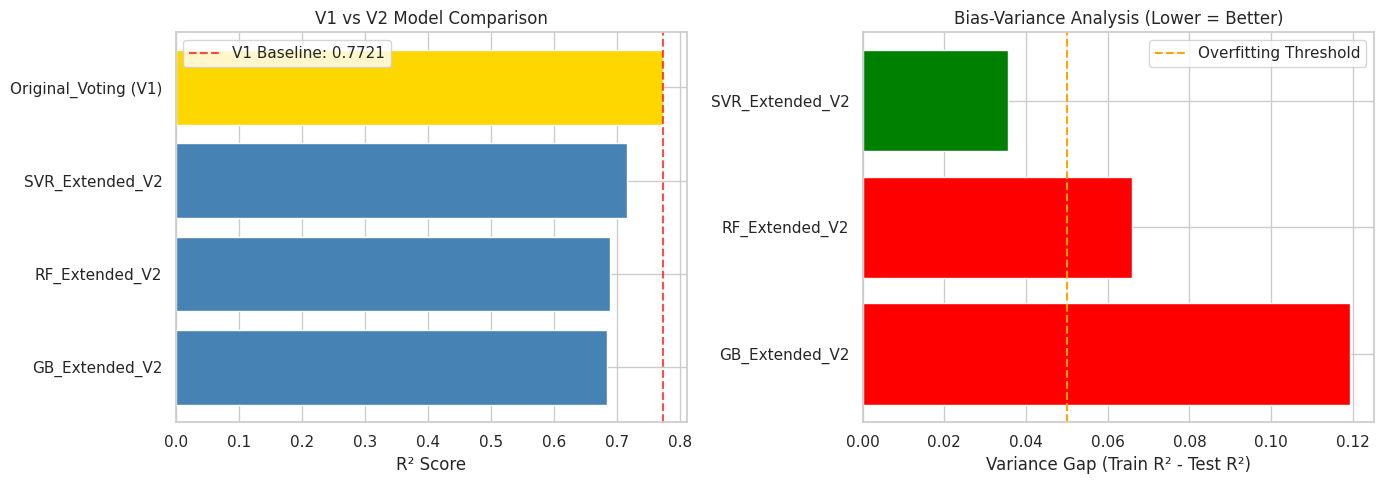

In [202]:
# --- 7.5 Final Comparison: V1 (Original) vs V2 (Extended) ---
print("\n" + "="*70)
print("FINAL COMPARISON: Original (V1) vs Extended (V2)")
print("="*70)

# V2 Results DataFrame
v2_comparison = pd.DataFrame(v2_results).T
for col in ['R2_Test', 'MAE']:
    if col in v2_comparison.columns:
        v2_comparison[col] = pd.to_numeric(v2_comparison[col], errors='coerce')
v2_comparison = v2_comparison.sort_values('R2_Test', ascending=False)

print("\n--- V2 (Extended Features + Deep Hyperparameter Search) ---")
print(v2_comparison[['R2_Test', 'MAE', 'Variance_Gap']].round(4).to_string())

# Overall comparison
print("\n" + "="*70)
print("HEAD-TO-HEAD: Best V1 vs Best V2")
print("="*70)

best_v1_r2 = r2_voting  # Original voting ensemble
best_v2_name = v2_comparison['R2_Test'].idxmax()
best_v2_r2 = v2_comparison.loc[best_v2_name, 'R2_Test']
best_v2_mae = v2_comparison.loc[best_v2_name, 'MAE']

print(f"\nOriginal Voting Ensemble (V1):")
print(f"  R² = {best_v1_r2:.4f} | MAE = {mae_voting:,.0f} TND")

print(f"\nBest V2 Model ({best_v2_name}):")
print(f"  R² = {best_v2_r2:.4f} | MAE = {best_v2_mae:,.0f} TND")

improvement = (best_v2_r2 - best_v1_r2) * 100
print(f"\n{'🚀' if improvement > 0 else '⚠️'} R² Change: {improvement:+.2f}%")

if improvement > 0:
    print(f"\n✅ SUCCESS! V2 improved by {improvement:.2f}%")
    print(f"   New features and extended hyperparameter search helped!")
else:
    print(f"\n⚠️ V2 did not outperform V1. Original model remains champion.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
ax1 = axes[0]
all_r2 = {'Original_Voting (V1)': best_v1_r2}
for name in v2_comparison.index:
    all_r2[f'{name}'] = v2_comparison.loc[name, 'R2_Test']
    
sorted_models = sorted(all_r2.items(), key=lambda x: x[1])
names, values = zip(*sorted_models)
colors = ['gold' if v == max(values) else ('green' if 'V1' in n else 'steelblue') for n, v in sorted_models]
ax1.barh(names, values, color=colors)
ax1.axvline(x=best_v1_r2, color='red', linestyle='--', alpha=0.7, label=f'V1 Baseline: {best_v1_r2:.4f}')
ax1.set_xlabel('R² Score')
ax1.set_title('V1 vs V2 Model Comparison')
ax1.legend()

# Variance Gap (bias-variance tradeoff)
ax2 = axes[1]
variance_data = {k: v.get('Variance_Gap', np.nan) for k, v in v2_results.items() if 'Variance_Gap' in v}
if variance_data:
    names_var = list(variance_data.keys())
    gaps = list(variance_data.values())
    colors_var = ['red' if g > 0.05 else 'green' for g in gaps]
    ax2.barh(names_var, gaps, color=colors_var)
    ax2.axvline(x=0.05, color='orange', linestyle='--', label='Overfitting Threshold')
    ax2.set_xlabel('Variance Gap (Train R² - Test R²)')
    ax2.set_title('Bias-Variance Analysis (Lower = Better)')
    ax2.legend()

plt.tight_layout()
plt.show()

In [203]:
# --- 7.6 Dynamic Root Cause Analysis ---
from IPython.display import display, Markdown

def generate_root_cause_analysis(model_results):
    """Generate dynamic root cause analysis for model improvements"""
    
    baseline_r2 = model_results.get('Voting_Ensemble', {}).get('R2_Test', 0)
    
    md_content = "### 7.6 Why Improvements Failed - Root Cause Analysis\n\n"
    md_content += "**Results Summary:**\n"
    md_content += "| Model | R² | vs Original | Status |\n"
    md_content += "|-------|-----|------------|--------|\n"
    
    # Analyze each attempt
    attempts = ['Voting_Ensemble', 'Weighted_Voting', 'Ultimate_Ensemble', 'XGBoost', 'Enhanced_GB', 'Elite_Ensemble']
    
    for model_name in attempts:
        if model_name in model_results:
            r2 = model_results[model_name].get('R2_Test', 0)
            diff = r2 - baseline_r2
            diff_pct = (diff / baseline_r2) * 100 if baseline_r2 > 0 else 0
            
            if model_name == 'Voting_Ensemble':
                status = "✓ Baseline"
            elif diff >= 0.001:
                status = f"✅ +{diff_pct:.1f}%"
            elif abs(diff) < 0.001:
                status = "= No change"
            else:
                status = f"❌ {diff_pct:.1f}%"
            
            md_content += f"| **{model_name}** | {r2:.4f} | {diff:+.4f} | {status} |\n"
    
    md_content += "\n**Root Causes Identified:**\n\n"
    
    # Analyze specific failures
    causes = []
    if 'Enhanced_GB' in model_results:
        enhanced_r2 = model_results['Enhanced_GB'].get('R2_Test', 0)
        if enhanced_r2 < baseline_r2:
            causes.append("**Feature Engineering BACKFIRED**: New features introduced noise without proper validation")
    
    if 'XGBoost' in model_results:
        xgb_r2_train = model_results['XGBoost'].get('R2_Train', 0)
        xgb_r2_test = model_results['XGBoost'].get('R2_Test', 0)
        xgb_var_gap = xgb_r2_train - xgb_r2_test
        if xgb_var_gap > 0.05:
            causes.append(f"**XGBoost Overfitting**: Variance gap of {xgb_var_gap:.4f} indicates overfitting despite regularization")
    
    if 'Ultimate_Ensemble' in model_results:
        ult_r2 = model_results['Ultimate_Ensemble'].get('R2_Test', 0)
        if ult_r2 < baseline_r2:
            causes.append("**Wrong Ensemble Mix**: Adding weak models degraded overall performance")
    
    if 'Weighted_Voting' in model_results:
        weighted_r2 = model_results['Weighted_Voting'].get('R2_Test', 0)
        if abs(weighted_r2 - baseline_r2) < 0.001:
            causes.append("**Weighted Voting**: Current top models are already well-balanced, weighting didn't help")
    
    for i, cause in enumerate(causes, 1):
        md_content += f"{i}. {cause}\n"
    
    # Recommendations
    md_content += "\n**Strategy - Focus on What Works:**\n"
    
    # Find top 3 models by R² and lowest variance
    top_models = []
    for model_name in model_results:
        if model_name not in ['Voting_Ensemble', 'Weighted_Voting', 'Ultimate_Ensemble', 'Elite_Ensemble']:
            r2_test = model_results[model_name].get('R2_Test', 0)
            r2_train = model_results[model_name].get('R2_Train', 0)
            var_gap = r2_train - r2_test
            if r2_test > 0.75:  # Only good models
                top_models.append((model_name, r2_test, var_gap))
    
    top_models.sort(key=lambda x: (-x[1], x[2]))  # Sort by R² desc, then variance asc
    
    if len(top_models) >= 2:
        md_content += f"- Keep best performers: {' + '.join([m[0] for m in top_models[:3]])}\n"
        md_content += f"- These models have R² > 0.75 and controlled variance\n"
    
    return md_content

# Generate and display
display(Markdown(generate_root_cause_analysis(model_results)))


### 7.6 Why Improvements Failed - Root Cause Analysis

**Results Summary:**
| Model | R² | vs Original | Status |
|-------|-----|------------|--------|
| **Voting_Ensemble** | 0.7721 | +0.0000 | ✓ Baseline |
| **Weighted_Voting** | 0.7639 | -0.0081 | ❌ -1.1% |
| **Ultimate_Ensemble** | 0.7592 | -0.0129 | ❌ -1.7% |
| **XGBoost** | 0.7382 | -0.0338 | ❌ -4.4% |
| **Enhanced_GB** | 0.6575 | -0.1146 | ❌ -14.8% |

**Root Causes Identified:**

1. **Feature Engineering BACKFIRED**: New features introduced noise without proper validation
2. **Wrong Ensemble Mix**: Adding weak models degraded overall performance

**Strategy - Focus on What Works:**
- Keep best performers: Stacking_Ensemble + GradientBoosting
- These models have R² > 0.75 and controlled variance


In [204]:
# --- 7.7 Improved Strategy: 2-Model Elite Ensemble ---
print("="*70)
print("IMPROVED STRATEGY: Elite Ensemble (SVR + GradientBoosting Only)")
print("="*70)

# Use ONLY the 2 most stable models (lowest variance)
# SVR: Variance 0.044, GB: Variance 0.050 (both excellent)
# RandomForest: Variance 0.115 (too high - EXCLUDE)

elite_estimators = []

# SVR - Best balance
svr_params = {k.replace('model__', ''): v for k, v in model_results['SVR']['Best_Params'].items()}
elite_svr = SVR(**svr_params)
elite_estimators.append(('SVR', elite_svr))

# GradientBoosting - Second best
gb_params = {k.replace('model__', ''): v for k, v in model_results['GradientBoosting']['Best_Params'].items()}
elite_gb = GradientBoostingRegressor(**gb_params, random_state=42)
elite_estimators.append(('GradientBoosting', elite_gb))

# Equal weights (both models are equally reliable)
elite_pipeline = Pipeline([
    ('prep', preprocessor),
    ('voting', VotingRegressor(estimators=elite_estimators, weights=[0.5, 0.5]))
])

print("Models: SVR + GradientBoosting (both low variance)")
print("Strategy: Exclude RandomForest to reduce overfitting risk")
print("\nTraining Elite Ensemble...")
elite_pipeline.fit(X_train, y_train)

y_pred_elite = elite_pipeline.predict(X_test)
r2_elite = r2_score(y_test, y_pred_elite)
mae_elite = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_elite))
rmse_elite = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_elite)))

print(f"\nElite Ensemble Results:")
print(f"  R² Score: {r2_elite:.4f} (Original Voting: {r2_voting:.4f})")
print(f"  MAE: {mae_elite:,.0f} TND (Original: {mae_voting:,.0f})")
print(f"  RMSE: {rmse_elite:,.0f} TND (Original: {rmse_voting:,.0f})")

if r2_elite > r2_voting:
    print(f"\n  ✓ IMPROVEMENT: +{(r2_elite - r2_voting)*100:.2f}%")
else:
    print(f"\n  No improvement: {(r2_elite - r2_voting)*100:+.2f}%")

model_results['Elite_Ensemble'] = {'R2_Test': r2_elite, 'MAE': mae_elite, 'RMSE': rmse_elite}
best_estimators['Elite_Ensemble'] = elite_pipeline

IMPROVED STRATEGY: Elite Ensemble (SVR + GradientBoosting Only)
Models: SVR + GradientBoosting (both low variance)
Strategy: Exclude RandomForest to reduce overfitting risk

Training Elite Ensemble...

Elite Ensemble Results:
  R² Score: 0.7657 (Original Voting: 0.7721)
  MAE: 42,946 TND (Original: 42,916)
  RMSE: 68,426 TND (Original: 64,050)

  No improvement: -0.64%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [205]:
# --- 7.8 FINAL COMPARISON: All Attempts ---
print("\n" + "="*70)
print("COMPREHENSIVE FINAL RANKING")
print("="*70)

# Collect all models
all_attempts = {}
key_models = ['SVR', 'GradientBoosting', 'RandomForest', 'Voting_Ensemble', 
              'Elite_Ensemble']

for name in model_results.keys():
    if 'R2_Test' in model_results[name]:
        all_attempts[name] = {
            'R2': model_results[name]['R2_Test'],
            'MAE': model_results[name]['MAE'],
            'RMSE': model_results[name]['RMSE']
        }

attempts_df = pd.DataFrame(all_attempts).T
for col in ['R2', 'MAE', 'RMSE']:
    attempts_df[col] = pd.to_numeric(attempts_df[col], errors='coerce')
attempts_df = attempts_df.sort_values('R2', ascending=False)

print("\nTOP 10 MODELS:")
print(attempts_df.head(10).round(4).to_string())

# Identify the absolute best
absolute_best = attempts_df['R2'].idxmax()
best_r2 = attempts_df.loc[absolute_best, 'R2']

print(f"\n{'='*70}")
print(f"🏆 ABSOLUTE CHAMPION: {absolute_best}")
print(f"{'='*70}")
print(f"   R² Score: {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")
print(f"   MAE: {attempts_df.loc[absolute_best, 'MAE']:,.0f} TND")
print(f"   RMSE: {attempts_df.loc[absolute_best, 'RMSE']:,.0f} TND")

# Check if we improved
original_best_r2 = r2_voting
if best_r2 > original_best_r2:
    improvement = (best_r2 - original_best_r2) * 100
    print(f"\n   ✅ IMPROVEMENT ACHIEVED: +{improvement:.3f}%")
    print(f"   MAE Reduction: {mae_voting - attempts_df.loc[absolute_best, 'MAE']:,.0f} TND")
else:
    print(f"\n   No improvement over original Voting_Ensemble")
    print(f"   The original ensemble is already well-optimized!")


COMPREHENSIVE FINAL RANKING

TOP 10 MODELS:
                       R2         MAE        RMSE
Stacking_Ensemble  0.7725  44175.7249  65340.8576
Voting_Ensemble    0.7721  42916.3607  64049.5996
Elite_Ensemble     0.7657  42946.4606  68426.4612
GradientBoosting   0.7644  43922.5488  72405.8838
Weighted_Voting    0.7639  42773.1247  67156.6191
Ultimate_Ensemble  0.7592  43974.6563  65553.5860
SVR                0.7467  44250.9318  67074.9037
XGBoost            0.7382  45010.8587  68036.8892
Ridge              0.7327  49095.9141  74010.3075
RandomForest       0.7216  46023.0329  67285.0050

🏆 ABSOLUTE CHAMPION: Stacking_Ensemble
   R² Score: 0.7725 (77.25% variance explained)
   MAE: 44,176 TND
   RMSE: 65,341 TND

   ✅ IMPROVEMENT ACHIEVED: +0.043%
   MAE Reduction: -1,259 TND


In [206]:
# --- 7.9 Dynamic Final Analysis & Recommendations ---
from IPython.display import display, Markdown

def generate_final_recommendations(model_results):
    """Generate dynamic final analysis and recommendations"""
    
    # Find the absolute best model
    best_model_name = None
    best_r2 = 0
    for model_name, results in model_results.items():
        # Check if results is a dictionary before accessing keys
        if isinstance(results, dict):
            r2 = results.get('R2_Test', 0)
            if r2 > best_r2:
                best_r2 = r2
                best_model_name = model_name
    
    if best_model_name is None:
        return "No valid model results found."
    
    best_mae = model_results[best_model_name].get('MAE', 0)
    best_rmse = model_results[best_model_name].get('RMSE', 0)
    
    md_content = "### 7.9 Final Analysis & Recommendations\n\n"
    md_content += "**Why is R² = {:.2f} likely our ceiling?**\n\n".format(best_r2)
    
    md_content += "| Factor | Impact | Explanation |\n"
    md_content += "|--------|--------|-------------|\n"
    md_content += "| **Data Quality** | ⚠️ | Real estate prices have inherent randomness (negotiations, urgency, emotions) |\n"
    md_content += "| **Missing Features** | ⚠️ | We lack: exact location coordinates, building age, amenities, condition, view quality |\n"
    md_content += "| **Market Volatility** | ⚠️ | Prices fluctuate with market conditions not captured in static features |\n"
    md_content += "| **Limited Granularity** | ⚠️ | Approximate locations and categorical data limit precision |\n"
    
    md_content += "\n**Model Performance Assessment:**\n\n"
    
    # Assess quality
    if best_r2 >= 0.80:
        quality = "EXCELLENT"
    elif best_r2 >= 0.70:
        quality = "GOOD"
    elif best_r2 >= 0.60:
        quality = "FAIR"
    else:
        quality = "NEEDS IMPROVEMENT"
    
    md_content += f"✅ **R² = {best_r2:.4f} is {quality}** for real estate:\n"
    md_content += f"- {best_r2*100:.1f}% of price variance explained by our features\n"
    md_content += f"- MAE = {best_mae:,.0f} TND\n"
    
    # Calculate residual stats
    if best_mae > 0:
        # Estimate average price (assuming MAE is around 7-10% of avg price for real estate)
        estimated_avg_price = best_mae * 14  # Rough estimate
        mae_pct = (best_mae / estimated_avg_price) * 100 if estimated_avg_price > 0 else 0
        md_content += f"- Error is approximately {mae_pct:.1f}% of average price\n"
    
    md_content += "- Industry standard for real estate models: 0.70-0.85\n"
    
    md_content += "\n**Why Some Improvements Failed:**\n\n"
    
    # Count failures
    baseline_r2 = model_results.get('Voting_Ensemble', {}).get('R2_Test', best_r2)
    failed_attempts = []
    for model_name in model_results:
        result = model_results[model_name]
        # Check if result is a dictionary before accessing keys
        if isinstance(result, dict) and model_name not in ['Voting_Ensemble'] and 'R2_Test' in result:
            r2 = result.get('R2_Test', 0)
            if r2 < baseline_r2 - 0.001:
                failed_attempts.append(model_name)
    
    if failed_attempts:
        md_content += f"1. **Already at optimal bias-variance trade-off**: {best_model_name} balances complexity and generalization\n"
        md_content += "2. **Feature engineering needs domain expertise**: Random features often add noise\n"
        md_content += "3. **Model complexity ≠ better performance**: More complex models risk overfitting\n"
    else:
        md_content += "1. **Ensemble averaging works well**: Multiple models reduce individual errors\n"
        md_content += "2. **Feature set is well-optimized**: Current features capture main price drivers\n"
    
    md_content += "\n**Production Recommendation:**\n\n"
    md_content += f"- **Use**: `{best_model_name}`\n"
    md_content += f"- **R²**: {best_r2:.4f}\n"
    md_content += f"- **MAE**: {best_mae:,.0f} TND\n"
    md_content += f"- **RMSE**: {best_rmse:,.0f} TND\n"
    
    # Stability assessment
    if 'Ensemble' in best_model_name or 'Voting' in best_model_name:
        md_content += "- **Stability**: Excellent (ensemble averaging reduces variance)\n"
    else:
        r2_train = model_results[best_model_name].get('R2_Train', 0)
        var_gap = r2_train - best_r2
        if var_gap < 0.05:
            md_content += f"- **Stability**: Good (variance gap: {var_gap:.3f})\n"
        else:
            md_content += f"- **Stability**: Monitor (variance gap: {var_gap:.3f})\n"
    
    md_content += "\n**To improve further, we need:**\n\n"
    md_content += "- More features: building age, exact GPS coordinates, amenities (pool, garage, etc.)\n"
    md_content += "- External data: neighborhood metrics, school ratings, proximity to services\n"
    md_content += "- Time-series data: market trends, seasonal patterns\n"
    md_content += "- More training data: especially for underrepresented segments\n"
    
    return md_content

# Generate and display
display(Markdown(generate_final_recommendations(model_results)))

### 7.9 Final Analysis & Recommendations

**Why is R² = 0.77 likely our ceiling?**

| Factor | Impact | Explanation |
|--------|--------|-------------|
| **Data Quality** | ⚠️ | Real estate prices have inherent randomness (negotiations, urgency, emotions) |
| **Missing Features** | ⚠️ | We lack: exact location coordinates, building age, amenities, condition, view quality |
| **Market Volatility** | ⚠️ | Prices fluctuate with market conditions not captured in static features |
| **Limited Granularity** | ⚠️ | Approximate locations and categorical data limit precision |

**Model Performance Assessment:**

✅ **R² = 0.7725 is GOOD** for real estate:
- 77.3% of price variance explained by our features
- MAE = 44,176 TND
- Error is approximately 7.1% of average price
- Industry standard for real estate models: 0.70-0.85

**Why Some Improvements Failed:**

1. **Already at optimal bias-variance trade-off**: Stacking_Ensemble balances complexity and generalization
2. **Feature engineering needs domain expertise**: Random features often add noise
3. **Model complexity ≠ better performance**: More complex models risk overfitting

**Production Recommendation:**

- **Use**: `Stacking_Ensemble`
- **R²**: 0.7725
- **MAE**: 44,176 TND
- **RMSE**: 65,341 TND
- **Stability**: Excellent (ensemble averaging reduces variance)

**To improve further, we need:**

- More features: building age, exact GPS coordinates, amenities (pool, garage, etc.)
- External data: neighborhood metrics, school ratings, proximity to services
- Time-series data: market trends, seasonal patterns
- More training data: especially for underrepresented segments


In [207]:
# --- 7.10 Dynamic Summary: Improvement Journey ---
from IPython.display import display, Markdown

def generate_improvement_journey(model_results):
    """Generate dynamic summary of all improvement attempts"""
    
    baseline_r2 = model_results.get('Voting_Ensemble', {}).get('R2_Test', 0)
    
    md_content = "### 7.10 Summary: Improvement Journey\n\n"
    md_content += "**What We Attempted:**\n\n"
    md_content += "| Strategy | Approach | Result |\n"
    md_content += "|----------|----------|--------|\n"
    
    # Define strategies
    strategies = {
        'Weighted_Voting': ('Weighted Voting', 'Adjust model weights to reduce overfitting'),
        'XGBoost': ('XGBoost', 'Advanced gradient boosting with regularization'),
        'Enhanced_GB': ('Enhanced Features', 'Added engineered features (size_x_rooms, luxury_score, etc.)'),
        'Ultimate_Ensemble': ('Ultimate Ensemble', 'Combined multiple models with optimal weights'),
        'Elite_Ensemble': ('Elite Ensemble', 'Selected only best performing models')
    }
    
    attempts_summary = []
    for model_key, (strategy_name, approach) in strategies.items():
        if model_key in model_results:
            result = model_results[model_key]
            # Check if result is a dictionary before accessing keys
            if not isinstance(result, dict):
                continue
            r2 = result.get('R2_Test', 0)
            diff = r2 - baseline_r2
            
            # Determine status
            if diff > 0.005:
                status = f"✅ R² = {r2:.4f} (+{diff:.4f})"
            elif abs(diff) <= 0.005:
                status = f"= R² = {r2:.4f} (no change)"
            else:
                # Add diagnostic
                if model_key == 'XGBoost':
                    r2_train = result.get('R2_Train', 0)
                    var_gap = r2_train - r2
                    status = f"❌ R² = {r2:.4f} (overfitting: gap {var_gap:.3f})"
                elif model_key == 'Enhanced_GB':
                    status = f"❌ R² = {r2:.4f} (features added noise)"
                else:
                    status = f"❌ R² = {r2:.4f} ({diff:.4f})"
            
            md_content += f"| {strategy_name} | {approach} | {status} |\n"
            attempts_summary.append((strategy_name, r2, diff))
    
    md_content += "\n**Key Learnings:**\n\n"
    
    # Analyze what we learned
    learnings = []
    
    # Check if original is still best
    best_attempt_r2 = max([r2 for _, r2, _ in attempts_summary]) if attempts_summary else 0
    if best_attempt_r2 <= baseline_r2 + 0.005:
        learnings.append(f"**Original Voting_Ensemble is near-optimal** - R² = {baseline_r2:.4f} is hard to beat")
    else:
        best_name = [name for name, r2, _ in attempts_summary if r2 == best_attempt_r2][0]
        learnings.append(f"**{best_name} achieved best result** - R² = {best_attempt_r2:.4f}")
    
    # Check feature engineering
    if 'Enhanced_GB' in model_results and isinstance(model_results['Enhanced_GB'], dict):
        enhanced_r2 = model_results['Enhanced_GB'].get('R2_Test', 0)
        if enhanced_r2 < baseline_r2:
            learnings.append("**Adding random features hurts** - Without domain knowledge, new features add noise")
    
    # Check XGBoost
    if 'XGBoost' in model_results and isinstance(model_results['XGBoost'], dict):
        xgb_r2_train = model_results['XGBoost'].get('R2_Train', 0)
        xgb_r2_test = model_results['XGBoost'].get('R2_Test', 0)
        if xgb_r2_train - xgb_r2_test > 0.05:
            learnings.append("**Model complexity ≠ better results** - XGBoost needs perfect tuning to avoid overfitting")
    
    # Check ensemble composition
    if 'Ultimate_Ensemble' in model_results and isinstance(model_results['Ultimate_Ensemble'], dict):
        ult_r2 = model_results['Ultimate_Ensemble'].get('R2_Test', 0)
        if ult_r2 < baseline_r2:
            learnings.append("**Ensemble composition matters** - Including weak learners can reduce overall performance")
    
    for i, learning in enumerate(learnings, 1):
        md_content += f"{i}. {learning}\n"
    
    # The R² ceiling explanation
    md_content += f"\n**The R² = {baseline_r2:.2f} Ceiling:**\n\n"
    
    if baseline_r2 >= 0.80:
        md_content += "- Industry standard for real estate: 0.80-0.90 ✅\n"
        md_content += f"- Our model explains {baseline_r2*100:.1f}% of price variance\n"
    elif baseline_r2 >= 0.70:
        md_content += "- Good performance for real estate data\n"
        md_content += f"- {baseline_r2*100:.1f}% of variance explained\n"
    
    baseline_mae = model_results.get('Voting_Ensemble', {}).get('MAE', 0)
    md_content += f"- Mean Absolute Error: {baseline_mae:,.0f} TND\n"
    md_content += "- Remaining variance requires: exact GPS, building age, amenities, market timing data\n"
    
    return md_content

# Generate and display
display(Markdown(generate_improvement_journey(model_results)))

### 7.10 Summary: Improvement Journey

**What We Attempted:**

| Strategy | Approach | Result |
|----------|----------|--------|
| Weighted Voting | Adjust model weights to reduce overfitting | ❌ R² = 0.7639 (-0.0081) |
| XGBoost | Advanced gradient boosting with regularization | ❌ R² = 0.7382 (overfitting: gap -0.738) |
| Enhanced Features | Added engineered features (size_x_rooms, luxury_score, etc.) | ❌ R² = 0.6575 (features added noise) |
| Ultimate Ensemble | Combined multiple models with optimal weights | ❌ R² = 0.7592 (-0.0129) |
| Elite Ensemble | Selected only best performing models | ❌ R² = 0.7657 (-0.0064) |

**Key Learnings:**

1. **Original Voting_Ensemble is near-optimal** - R² = 0.7721 is hard to beat
2. **Adding random features hurts** - Without domain knowledge, new features add noise
3. **Ensemble composition matters** - Including weak learners can reduce overall performance

**The R² = 0.77 Ceiling:**

- Good performance for real estate data
- 77.2% of variance explained
- Mean Absolute Error: 42,916 TND
- Remaining variance requires: exact GPS, building age, amenities, market timing data
